# Create MODIS grid, output tile list, and create empty zarr store

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets
import modis_masking
import xarray as xr
import dask
import zarr
import adlfs
import pathlib
import rioxarray

## Create grid and tile processing list

In [2]:
modis_grid = gpd.read_file('zip+http://book.ecosens.org/wp-content/uploads/2016/06/modis_grid.zip!modis_sinusoidal_grid_world.shp')
land = gpd.read_file(geodatasets.get_url('naturalearth land'))
land_modis_crs = gpd.GeoSeries(land.union_all(), crs='EPSG:4326').to_crs(modis_grid.crs)
modis_grid_land_idx = modis_grid.intersects(land_modis_crs.union_all())
modis_grid_land_idx[600] = False
modis_grid_land = modis_grid[modis_grid_land_idx]
modis_grid_not_land = modis_grid[~modis_grid_land_idx]
modis_grid_land_list = list(modis_grid_land.iterrows())
tile_processing_list = [f'h{tile["h"]}_v{tile["v"]}' for _, tile in modis_grid_land_list]

## Output tile processing list

In [3]:
# output tile processing list to a text file (overwrite the text file if it already exists)
with open('modis_tile_processing_list.txt', 'w') as f:
    for tile in tile_processing_list:
        f.write(f'{tile}\n')

## Plot MODIS grid

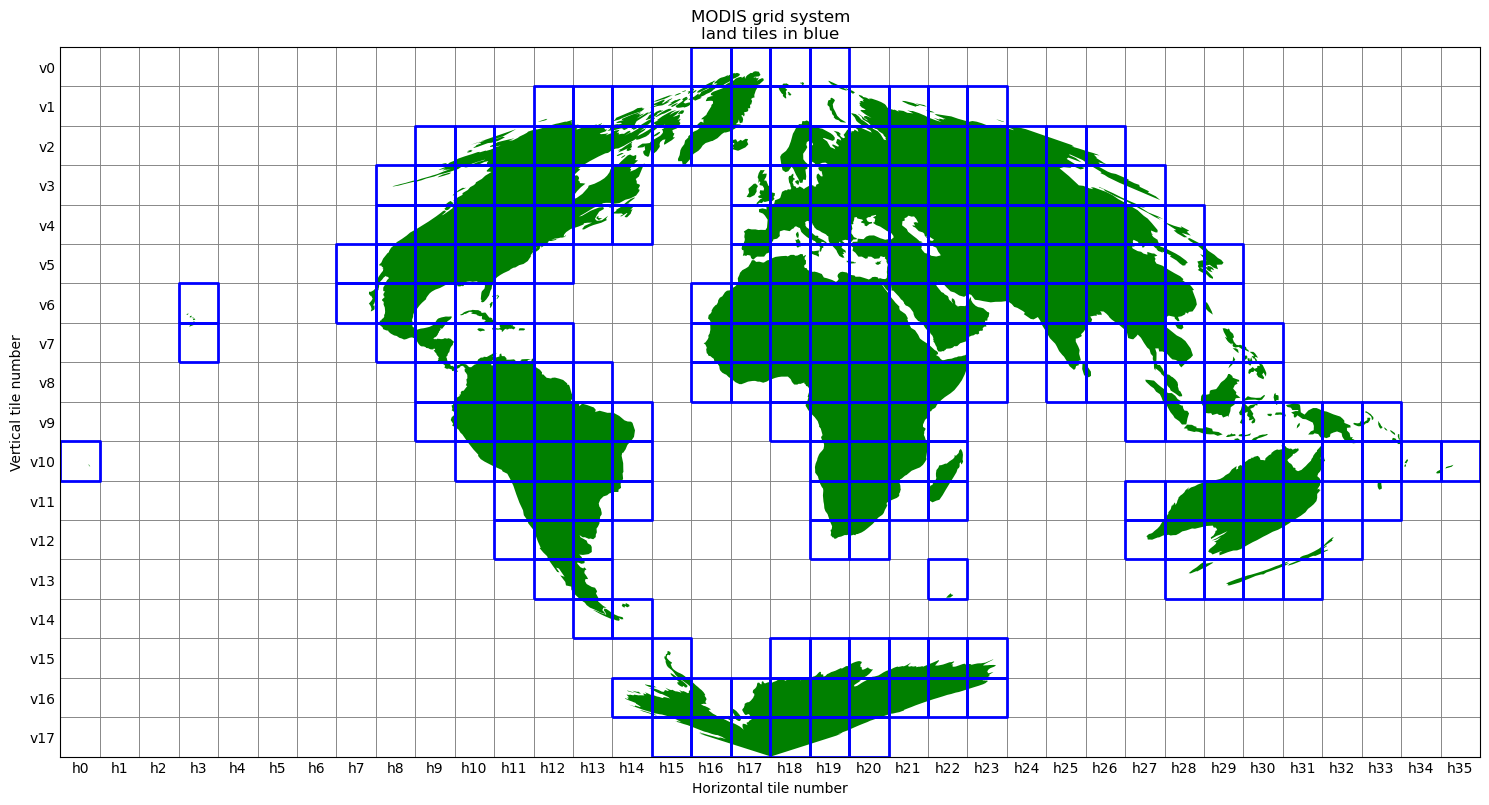

In [4]:
f, ax = plt.subplots(figsize=(15,15))
land_modis_crs.plot(ax=ax, color='green')
modis_grid_not_land.geometry.boundary.plot(ax=ax, color='gray', linewidth=0.5)
modis_grid_land.geometry.boundary.plot(ax=ax, color='blue', linewidth=2)

h_values = sorted(modis_grid['h'].unique())
v_values = sorted(modis_grid['v'].unique(), reverse=True)

h_coords = [modis_grid[modis_grid['h'] == h].geometry.centroid.x.mean() for h in h_values]
v_coords = [modis_grid[modis_grid['v'] == v].geometry.centroid.y.mean() for v in v_values]

ax.set_xticks(h_coords)
ax.set_xticklabels([f'h{h}' for h in h_values])
ax.set_yticks(v_coords)
ax.set_yticklabels([f'v{v}' for v in v_values])

ax.tick_params(axis='both', which='both', length=0)


ax.set_title('MODIS grid system\nland tiles in blue')
ax.set_xlabel('Horizontal tile number')
ax.set_ylabel('Vertical tile number')

ax.set_xlim(modis_grid.total_bounds[0], modis_grid.total_bounds[2])
ax.set_ylim(modis_grid.total_bounds[1], modis_grid.total_bounds[3])


ax.set_title('MODIS grid system\nland tiles in blue')
f.tight_layout()


## Now create empty zarr store

In [5]:
WY_start = 2015
WY_end = 2024
sas_token = pathlib.Path('sas_token.txt').read_text()
store = adlfs.AzureBlobFileSystem(account_name="snowmelt", credential=sas_token).get_mapper("snowmelt/snow_cover/global_modis_snow_cover_4.zarr")

In [6]:
def create_azure_zarr_store(store):

    water_years = np.arange(WY_start, WY_end + 1)
    num_years = len(water_years)

    modis_snow_entire_extent_footprint = modis_masking.get_modis_MOD10A2_full_grid()
    y = modis_snow_entire_extent_footprint.y.values
    x = modis_snow_entire_extent_footprint.x.values

    shape = (num_years, 18 * 2400, 36 * 2400)
    chunks = (1, 2400, 2400)  
    
    nodata_type = np.int16

    fill_value = np.iinfo(nodata_type).min

    ds = xr.Dataset(
        {
            'SAD_DOWY': (('water_year', 'y', 'x'), dask.array.full(shape, fill_value=fill_value, chunks=-1, dtype=nodata_type)),
            'SDD_DOWY': (('water_year', 'y', 'x'), dask.array.full(shape, fill_value=fill_value, chunks=-1, dtype=nodata_type)),
            'max_consec_snow_days': (('water_year', 'y', 'x'), dask.array.full(shape, fill_value=fill_value, chunks=-1, dtype=nodata_type)),
        },
        coords={
            'water_year': water_years,
            'y': y,
            'x': x,
        }
    )

    ds.water_year.attrs['description'] = ("Water year. In northern hemisphere, water year starts on October 1st "
                                    "and ends on September 30th. For the southern hemisphere, water year "
                                    "starts on April 1st and ends on March 31st. e.g. in NH WY 2015 is "
                                    "[2014-10-01,2015-09-30] and in SH WY 2015 is [2015-04-01,2016-03-31].")

    ds.attrs['processed_tiles'] = []

    encoding = {
        var: {
            "chunks": chunks,
            "compressor": zarr.Blosc(
                cname="zstd"
            ),
            "_FillValue": fill_value,
            "dtype": nodata_type,
        }
        for var in ds.data_vars
    }

    ds.rio.write_crs(modis_snow_entire_extent_footprint.rio.crs, inplace=True)

    # https://github.com/pydata/xarray/issues/6288#issuecomment-1230970216
    for var in ds.data_vars:
        ds[str(var)].attrs['grid_mapping'] = 'spatial_ref' 

    ds.to_zarr(store, 
               mode='w', 
               encoding=encoding, 
               compute=False, 
               consolidated=True, 
               write_empty_chunks=False, 
               #zarr_format=3
               )

    return ds


In [7]:
start_fresh = False

if start_fresh:
    zarr_store_ds = create_azure_zarr_store(store)
    zarr_store_ds